In [1]:
# Import Packages
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import cv2
import glob
from keras.utils import plot_model
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10394702819377723257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14574658699780946195
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [3]:
# DeepFashion Dataset Path
train_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/train'
validation_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/validation'
test_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/test'

# Setting the Parameters & Hyperparameters

# 1
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 32
# batch_size_validation = 32
# epochs = 10
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# # 2
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 20
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# # 3
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 3
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# 4
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 10
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# 5
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 26
drop_rate = 0.25
learning_rate = 0.0001
momentum_num = 0.99
plot_num_rows = 3
plot_num_rows = 3

In [4]:
# Initialize the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_row, img_col, img_channel))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3974212240> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f38d003e6a0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f38708cc400> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f387087d978> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3870885a20> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f387087deb8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3870889ef0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3870890cc0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3870895ef0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3870890080> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3870018da0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3870023

In [5]:
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Dense(category_nums, activation='softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [6]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                26650     
Total params: 40,436,570
Trainable params: 40,434,522
Non-trainable params: 2,048
________________________________________

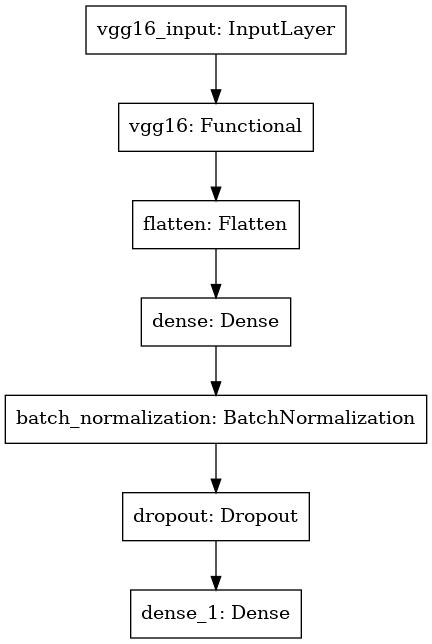

In [8]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/plot/model_summary5.jpg')

In [9]:
def data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col):

    # Train
    imgdatagen_train = ImageDataGenerator(
        rescale=1./255
    )

    train_dataset = imgdatagen_train.flow_from_directory(
        train_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_train,
        class_mode='categorical',
        shuffle=True
    )

    # Validation
    imgdatagen_validatioin = ImageDataGenerator(
        rescale=1./255
    )

    validation_dataset = imgdatagen_validatioin.flow_from_directory(
        validation_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_validation,
        class_mode='categorical',
        shuffle=True
    )

    # Test
    imgdatagen_test = ImageDataGenerator(
        rescale=1./255
    )
    
    test_dataset = imgdatagen_test.flow_from_directory(
        test_path,
        target_size=(img_row, img_col),
        class_mode='categorical',
        shuffle=True
    )
    
    return train_dataset, validation_dataset, test_dataset

In [10]:
train_dataset, validation_dataset, test_dataset = data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col)

X_train, y_train = next(train_dataset)

print(X_train.shape)
print(y_train.shape)
print(y_train[1,:])

X_val, y_val = next(validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(test_dataset)

print(X_test.shape)
print(y_test.shape)

Found 204406 images belonging to 26 classes.
Found 39055 images belonging to 26 classes.
Found 39065 images belonging to 26 classes.
(64, 224, 224, 3)
(64, 26)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(64, 224, 224, 3)
(64, 26)
(32, 224, 224, 3)
(32, 26)


In [11]:
# Class Distribution of Train dataset
train_dataset_class_indices = train_dataset.class_indices
print("class indices of train dataset: ",train_dataset_class_indices)

class indices of train dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Nightdress': 12, 'Parka': 13, 'Poncho': 14, 'Romper': 15, 'Shirtdress': 16, 'Shirts': 17, 'Shorts': 18, 'Skirt': 19, 'Sundress': 20, 'Sweater': 21, 'Tank': 22, 'Tee': 23, 'Top': 24, 'Trunks': 25}


In [12]:
# print(train_dataset.filenames[:20])

# category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in train_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))


[('Dress', 52137), ('Tee', 26652), ('Blouse', 19524), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Sweater', 9615), ('Cardigan', 9605), ('Jacket', 7897), ('Top', 7269), ('Jeans', 5568), ('Romper', 5424), ('Blazer', 5407), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Hoodie', 2909), ('Coat', 1601), ('Cutoffs', 1176), ('Shirts', 763), ('Poncho', 578), ('Parka', 490), ('Trunks', 286)]
204383


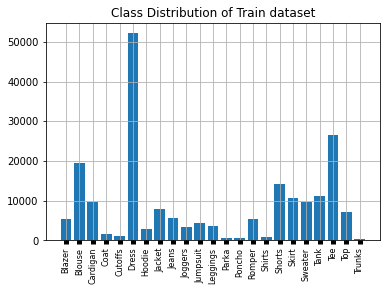

In [13]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [14]:
# Class Distribution of validation dataset
validation_dataset_class_indices = validation_dataset.class_indices
print("class indices of validation dataset: ", validation_dataset_class_indices)

class indices of validation dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Nightdress': 12, 'Parka': 13, 'Poncho': 14, 'Romper': 15, 'Shirtdress': 16, 'Shirts': 17, 'Shorts': 18, 'Skirt': 19, 'Sundress': 20, 'Sweater': 21, 'Tank': 22, 'Tee': 23, 'Top': 24, 'Trunks': 25}


In [15]:
category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in validation_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

[('Dress', 10051), ('Tee', 5142), ('Blouse', 3725), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Sweater', 1839), ('Cardigan', 1827), ('Jacket', 1529), ('Top', 1396), ('Jeans', 1051), ('Blazer', 1039), ('Romper', 988), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Shirts', 129), ('Poncho', 105), ('Parka', 97), ('Trunks', 57)]
39032


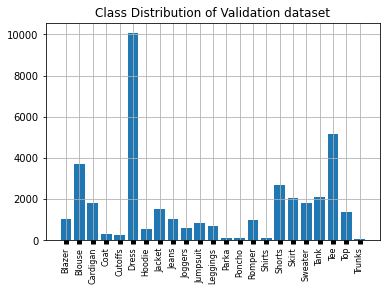

In [16]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [17]:
test_dataset_class_indices = test_dataset.class_indices
print("class indices of test dataset: ", test_dataset_class_indices)

class indices of test dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Nightdress': 12, 'Parka': 13, 'Poncho': 14, 'Romper': 15, 'Shirtdress': 16, 'Shirts': 17, 'Shorts': 18, 'Skirt': 19, 'Sundress': 20, 'Sweater': 21, 'Tank': 22, 'Tee': 23, 'Top': 24, 'Trunks': 25}


In [18]:
category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in test_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

[('Dress', 9967), ('Tee', 5090), ('Blouse', 3779), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1812), ('Jacket', 1507), ('Top', 1410), ('Jeans', 1048), ('Blazer', 1046), ('Romper', 993), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Coat', 320), ('Cutoffs', 242), ('Shirts', 151), ('Poncho', 105), ('Parka', 86), ('Trunks', 40)]
39042


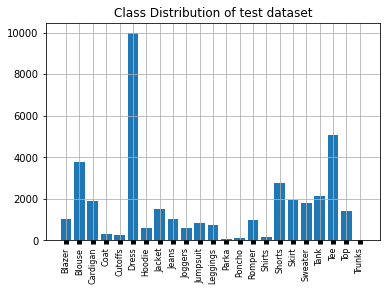

In [19]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [20]:
class_labels = list(validation_dataset.class_indices.keys())
num_imgs_validation = len(validation_dataset.filenames)
num_imgs_train = len(train_dataset.filenames)
num_imgs_test = len(test_dataset.filenames)
print("class_labels_keys: ", class_labels)
print("Length of class_labels: ", len(class_labels))
print("Number of train images: ", num_imgs_train)
print("Number of validation images: ", num_imgs_validation)
print("Number of test images: ", num_imgs_test)

class_labels_keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Nightdress', 'Parka', 'Poncho', 'Romper', 'Shirtdress', 'Shirts', 'Shorts', 'Skirt', 'Sundress', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
Length of class_labels:  26
Number of train images:  204406
Number of validation images:  39055
Number of test images:  39065


In [21]:
# Plotting Accuracy & Loss Curves
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/plot/DeepFashionVGG16CurvesAcc5.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/plot/DeepFashionVGG16CurvesLoss5.jpg')
    plt.show()

In [22]:
# Register Callbacks
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/output/csvlogger/model_train5.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=500, verbose=1, mode='min'
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/output/my_checkpoint5.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, check_point]
    return callback_list

In [23]:
callback_list = callback()

In [24]:
# Fine-tune the model - Training
def fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=(X_val, y_val),
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_dataset,
        verbose=1
    )

    return model, history, score

Epoch 1/10
3194/3194 [==============================] - 2753s 856ms/step - loss: 1.3164 - accuracy: 0.6195 - val_loss: 1.0206 - val_accuracy: 0.7031
Epoch 2/10
3194/3194 [==============================] - 2699s 845ms/step - loss: 0.8967 - accuracy: 0.7219 - val_loss: 0.9237 - val_accuracy: 0.7656
Epoch 3/10
3194/3194 [==============================] - 2697s 844ms/step - loss: 0.7880 - accuracy: 0.7539 - val_loss: 0.9427 - val_accuracy: 0.7188
Epoch 4/10
3194/3194 [==============================] - 2694s 843ms/step - loss: 0.6856 - accuracy: 0.7844 - val_loss: 0.9100 - val_accuracy: 0.6719
Epoch 5/10
3194/3194 [==============================] - 2682s 840ms/step - loss: 0.5643 - accuracy: 0.8178 - val_loss: 0.8134 - val_accuracy: 0.7812
Epoch 6/10
3194/3194 [==============================] - 2682s 840ms/step - loss: 0.4152 - accuracy: 0.8656 - val_loss: 1.1802 - val_accuracy: 0.6406
Epoch 7/10
3194/3194 [==============================] - 2680s 839ms/step - loss: 0.2573 - accuracy: 0.9181

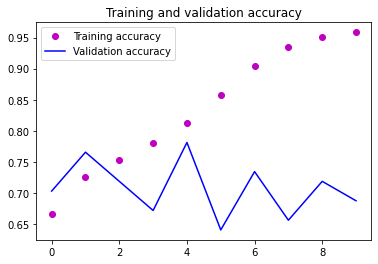

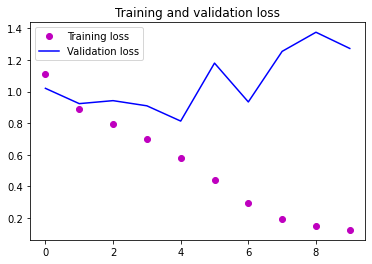

Validation Accuracy:0.7118678689002991 
Validation Loss:1.465909719467163


In [25]:
model, history, score = fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

# Model Save
model.save('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/save_model/my_model5.h5')

In [26]:
# Prediction
model.load_weights('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/output/my_checkpoint5.ckpt')
Y_pred = model.predict(test_dataset)

KeyboardInterrupt: 

In [ ]:
testY_labels = test_dataset.labels
print(testY_labels)
print(len(testY_labels))

In [ ]:
# Confusion Matrix and Classification Report
def confusion_mat(Y_pred, testY_labels, class_labels):
    y_pred = np.argmax(Y_pred, axis=1)
    confusion_mat = confusion_matrix(testY_labels, y_pred)
#     classification_rep = classification_report(testY_labels, y_pred, target_names=class_labels)
    plt.figure(figsize=(6, 4))
    df_confusion_mat = pd.DataFrame(confusion_mat)
    sns.heatmap(df_confusion_mat, annot_kws={"size": 1}, linewidths=.5, cmap='PuBu',
               annot=True, yticklabels=class_labels, xticklabels=class_labels, fmt='g'
               )
    plt.xticks(rotation=90)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/plot/DeepFashionVGG16_confusion_matrix5')
    return plt

In [ ]:
confusion_mat = confusion_mat(Y_pred, testY_labels, class_labels)

In [ ]:
model.load_weights('/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/output/my_checkpoint5.ckpt')

loss, acc = model.evaluate(X_test, y_test)
print("loss: ", loss)
print("acc: ", acc)

In [ ]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/flask-server/models/my_checkpoint5serving.tflite', 'wb').write(tflite_model)